In [1]:
import sys
sys.path.append("models/raster")

import os
import math
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from auxiliary.visualization import visualize_losses, visualize_confusion_matrix
from auxiliary.misc import send_notification, get_model_name

from cnn import CNN
from vit import ViT

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, then MPS, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    raster_path = "../scratch/raster"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    # local path
    raster_path = "../data.nosync/raster"
else:
    device = torch.device("cpu")
    # local path
    raster_path = "../data.nosync/raster"

print(f"Device set to: {device}")

Device set to: mps


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

In [5]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

### Loading the data

In [6]:
# Setting up a Dataset object for DataLoader
class BuildingRasterDataset(Dataset):
    def __init__(self, path, operators, attach_roads=True, transform=None):
        '''Stores the directory and filenames of the individual .npz files.'''
        # store directory of individual files
        self.path = path
        # get filenames of individual files
        #self.filenames = [file for file in os.listdir(path) if file.endswith(".npz")]
        # for testing purposes: take only the first 1000 files
        self.filenames = [file for file in os.listdir(path) if file.endswith(".npz")][:1000]

        # store indices of the operators within operator_order for slicing in the .__getitem__() method
        self.operators = operators

        # store information on whether roads should be attached
        self.attach_roads = attach_roads

        # store transformation
        self.transform = transform

    def __len__(self):
        '''Enables dataset length calculation.'''
        return len(self.filenames)

    def __getitem__(self, index):
        '''Enables indexing, returns block raster as features and generalization operators as label.'''
        # get filename associated with given index
        filename = self.filenames[index]

        # load the file with the filename
        sample = np.load(os.path.join(self.path, filename))

        # extract the rasters
        focal_building = sample["focal_building"]
        context_buildings = sample["context_buildings"]
        roads = sample["roads"]

        # stack the rasters according to attach_roads
        if self.attach_roads:
            # stack the rasters to shape (3, n_pixels, n_pixels)
            block = np.stack([focal_building, context_buildings, roads], axis=0)
        else:
            # leave out the roads, stack the rasters to shape (2, n_pixels, n_pixels)
            block = np.stack([focal_building, context_buildings], axis=0)

        # convert rasters to tensor
        block = torch.from_numpy(block).float()

        if self.transform:
            block = self.transform(block)

        # collect labels according to specified generalization operators
        operators = [torch.from_numpy(sample[operator]).float() for operator in self.operators]

        # stack the operators to a tensor
        operators = torch.stack(operators, dim=0).float()

        return block, operators

### Training pipeline

1) Design model (input, output size, forward pass)
2) Construct loss and optimizer
3) Training loop
     * Forward pass: Compute prediction
     * Backward pass: Compute gradients
     * Update weights

### Model design

Stride refers to the number of positions that the convolutional kernel shifts at one step. Input channel size of one layer should always be equal to the output channel size of the previous layer.

The application of convolution and pooling layers decreases the size of the image: The output after a convolution can be calculated according to the following formula, where $W$ is the input width, $F$ is the kernel size, $P$ is the padding and $S$ is the stride:

$$\frac{(W-F + 2 P)}{S} + 1$$

### Loss and activation function

Softmax is a common activation function, (binary) cross-Entropy is a common loss function for multiclass classification problems, sigmoid is commonly used for binary classification problems. When using the Pytorch implementation: no softmax in the last layer, class labels not one-hot encoded and no softmax. BCELoss requires an activation function at the end! Sigmoid are usually the last layers in binary classification probems.

If you don't know which activation function to use, just use ReLU, Leaky ReLU tries to adress vanishing gradient problem. Multiplies input with small negative numbers, as normal ReLU may cause many gradients to become zero, which means that the weights will never be updated. Whenever weights are not updated during training, use Leaky ReLU.

I am dealing with a multilabel (for each generalization operator), binary (operator present or absent) classification problem.

## Elimination model

In [7]:
# define path to training and validation data
path_to_training_data = os.path.join(raster_path, "training_data", "elimination", "training")
path_to_validation_data = os.path.join(raster_path, "training_data", "elimination", "validation")
path_to_test_data = os.path.join(raster_path, "training_data", "elimination", "test")

# define input parameters
elimination_operators = ["elimination"]
attach_roads = True

n_channels = 3 if attach_roads else 2
n_classes = len(elimination_operators)

# Creating model and moving to device
model = CNN(n_channels=n_channels, n_classes=n_classes)
#model = ViT(channels=n_channels, num_classes=n_classes)

model.to(device)
print(f"Using {model}")

learning_rate = 0.001

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using CNN with 2,670,433 parameters


### Training loop

In [8]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

# composing various random transforms that should be applied to the data
transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(0,0)),
        transforms.RandomRotation(degrees=(90,90)),
        transforms.RandomRotation(degrees=(180,180)),
        transforms.RandomRotation(degrees=(270,270))
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

# construct training DataLoader
training_set = BuildingRasterDataset(path_to_training_data, operators=elimination_operators, attach_roads=attach_roads, transform=transform)
training_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)

# construct validation DataLoader (no shuffling)
validation_set = BuildingRasterDataset(path_to_validation_data, operators=elimination_operators, attach_roads=attach_roads, transform=transform)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)

# construct test DataLoader (no transformations, no shuffling)
test_set = BuildingRasterDataset(path_to_test_data, operators=elimination_operators, attach_roads=attach_roads, transform=None)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

total_samples = len(training_set)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
training_losses = []
validation_losses = []

start_time = time.perf_counter()
    
for epoch in range(n_epochs):
    # tracking loss per epoch
    training_running_loss = 0.0
    n_training_batches = 0
    validation_running_loss = 0.0
    n_validation_batches = 0

    # training phase
    model.train()

    for i, (block, operators) in enumerate(training_loader):
        n_training_batches += 1
        
        # moving the features to device
        block = block.to(device)
        operators = operators.to(device)
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators_logits = model(block) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators_logits, operators) # calculate loss
        training_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iterations}")

    # validation phase
    model.eval()

    with torch.no_grad():
        for block, operators in validation_loader:
            n_validation_batches += 1
            
            # moving the features to device
            block = block.to(device)
            operators = operators.to(device)

            # prediction on the trained model results in logits
            pred_operators_logits = model(block)
            # calculate and store validation loss
            loss = criterion(pred_operators_logits, operators)
            validation_running_loss += loss.item()
    
    # print information at the end of each epoch
    training_loss_epoch = training_running_loss / n_training_batches
    training_losses.append(training_loss_epoch)
    validation_loss_epoch = validation_running_loss / n_validation_batches
    validation_losses.append(validation_loss_epoch)
    
    print(f"epoch {epoch+1} finished, training loss: {training_loss_epoch:.3f}, validation loss: {validation_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:,.3f} seconds")

# saving the losses
model_name = get_model_name(model, ops="eli", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
losses_path = os.path.join(raster_path, "model_outputs", "elimination", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=end_time-start_time)

1,000 samples in the training set.
250 samples in the validation set.
250 samples in the test set.
epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.695, validation loss: 0.699
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.693, validation loss: 0.698
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.693, validation loss: 0.698
epoch 4/10, step 6/63
epo

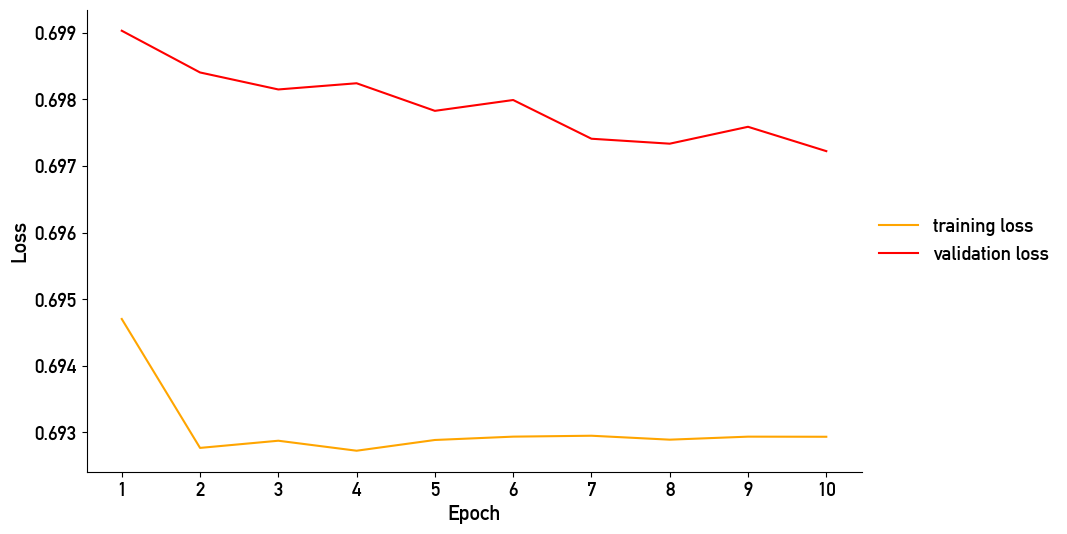

In [9]:
loss_path = os.path.join(raster_path, "model_outputs", "elimination", "losses")
visualize_losses([model_name], loss_path)

### Accuracy metrics after training

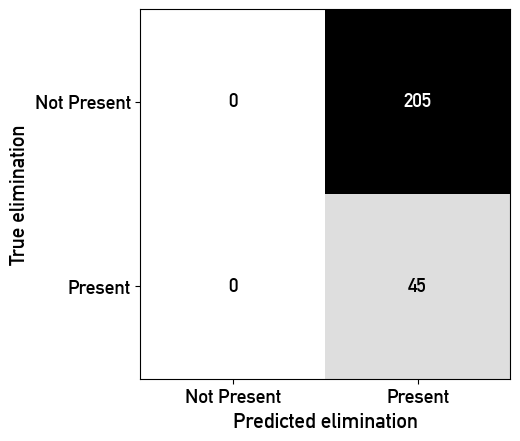

Accuracy: 0.180
Precision: 0.180
Recall: 1.000
F1 Score: 0.305


In [10]:
# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch
true_elimination = []
pred_elimination = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for block, operators in test_loader:
        
        # moving the features to device
        block = block.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(block)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # extracting true and predicted elimination
        true_elimination_batch = operators[:,0]
        pred_elimination_batch = pred_operators_labels[:,0]

        # collect data for metrics calculation
        true_elimination.append(true_elimination_batch.cpu())
        pred_elimination.append(pred_elimination_batch.cpu())

# convert lists to tensors
true_elimination = torch.cat(true_elimination)
pred_elimination = torch.cat(pred_elimination)

# calculate metrics
conf_matrix = confusion_matrix(true_elimination.numpy(), pred_elimination.numpy())
accuracy = accuracy_score(true_elimination.numpy(), pred_elimination.numpy())
precision = precision_score(true_elimination.numpy(), pred_elimination.numpy())
recall = recall_score(true_elimination.numpy(), pred_elimination.numpy())
f1 = f1_score(true_elimination.numpy(), pred_elimination.numpy())

# saving the accuracy metrics
model_name = get_model_name(model, ops="eli", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
metrics_path = os.path.join(raster_path, "model_outputs", "elimination", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame({"operator": ["elimination"],
                           "accuracy": [accuracy], 
                           "precision": [precision],
                           "recall": [recall],
                           "f1-score": [f1]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# display the confusion matrix
visualize_confusion_matrix(conf_matrix, operator="elimination")

# print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

### Saving the model

In [11]:
# save the trained model to disk
path_to_models = os.path.join(raster_path, "models", "elimination")

model_name = get_model_name(model, ops="eli", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

## Selection model

In [12]:
# define path to training and validation data
path_to_training_data = os.path.join(raster_path, "training_data", "selection", "training")
path_to_validation_data = os.path.join(raster_path, "training_data", "selection", "validation")
path_to_test_data = os.path.join(raster_path, "training_data", "selection", "test")

# define input parameters
selection_operators = ["aggregation", "typification", "displacement", "enlargement"]
attach_roads = True

n_channels = 3 if attach_roads else 2
n_classes = len(selection_operators)

# Creating model and moving to device
model = CNN(n_channels=n_channels, n_classes=n_classes)
#model = ViT(channels=n_channels, num_classes=n_classes)

model.to(device)
print(f"Using {model}")

learning_rate = 0.001

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using CNN with 3,272,644 parameters


### Training loop

In [13]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

# composing various random transforms that should be applied to the data
transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(0,0)),
        transforms.RandomRotation(degrees=(90,90)),
        transforms.RandomRotation(degrees=(180,180)),
        transforms.RandomRotation(degrees=(270,270))
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

# construct training DataLoader
training_set = BuildingRasterDataset(path_to_training_data, operators=selection_operators, attach_roads=attach_roads, transform=transform)
training_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)

# construct validation DataLoader (no shuffling)
validation_set = BuildingRasterDataset(path_to_validation_data, operators=selection_operators, attach_roads=attach_roads, transform=transform)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)

# construct test DataLoader (no transformations, no shuffling)
test_set = BuildingRasterDataset(path_to_test_data, operators=selection_operators, attach_roads=attach_roads, transform=None)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

total_samples = len(training_set)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
training_losses = []
validation_losses = []

start_time = time.perf_counter()
    
for epoch in range(n_epochs):
    # tracking loss per epoch
    training_running_loss = 0.0
    n_training_batches = 0
    validation_running_loss = 0.0
    n_validation_batches = 0

    # training phase
    model.train()

    for i, (block, operators) in enumerate(training_loader):
        n_training_batches += 1
        
        # moving the features to device
        block = block.to(device)
        operators = operators.to(device)
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators_logits = model(block) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators_logits, operators) # calculate loss
        training_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iterations}")

    # validation phase
    model.eval()

    with torch.no_grad():
        for block, operators in validation_loader:
            n_validation_batches += 1
            
            # moving the features to device
            block = block.to(device)
            operators = operators.to(device)

            # prediction on the trained model results in logits
            pred_operators_logits = model(block)
            # calculate and store validation loss
            loss = criterion(pred_operators_logits, operators)
            validation_running_loss += loss.item()
    
    # print information at the end of each epoch
    training_loss_epoch = training_running_loss / n_training_batches
    training_losses.append(training_loss_epoch)
    validation_loss_epoch = validation_running_loss / n_validation_batches
    validation_losses.append(validation_loss_epoch)
    
    print(f"epoch {epoch+1} finished, training loss: {training_loss_epoch:.3f}, validation loss: {validation_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:,.3f} seconds")

# saving the losses
model_name = get_model_name(model, ops="sel", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
losses_path = os.path.join(raster_path, "model_outputs", "selection", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=end_time-start_time)

1,000 samples in the training set.
250 samples in the validation set.
250 samples in the test set.
epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.688, validation loss: 0.688
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.687, validation loss: 0.687
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.682, validation loss: 0.680
epoch 4/10, step 6/63
epo

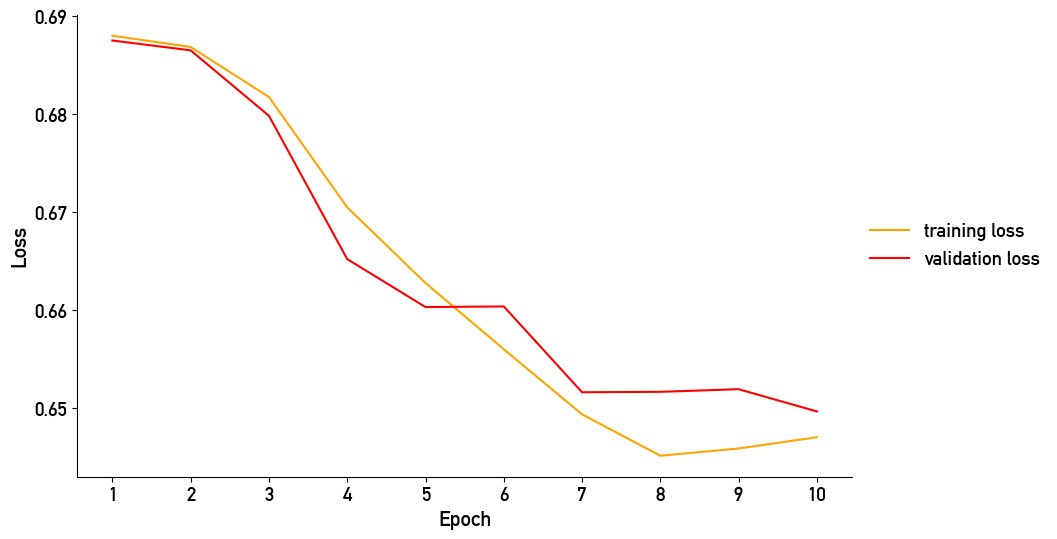

In [14]:
loss_path = os.path.join(raster_path, "model_outputs", "selection", "losses")
visualize_losses([model_name], loss_path)

### Accuracy metrics after training

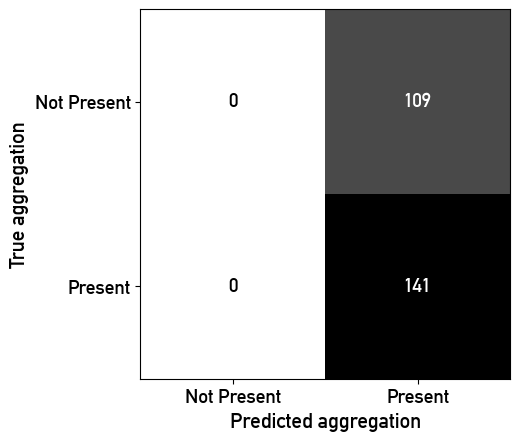

Accuracy: 0.564
Precision: 0.564
Recall: 1.000
F1 Score: 0.721


/Library/anaconda3/envs/genops/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


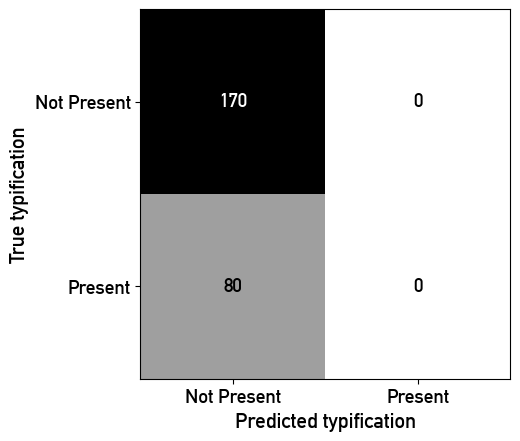

Accuracy: 0.680
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


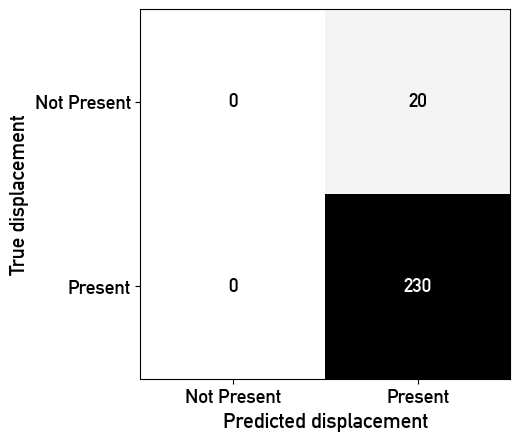

Accuracy: 0.920
Precision: 0.920
Recall: 1.000
F1 Score: 0.958


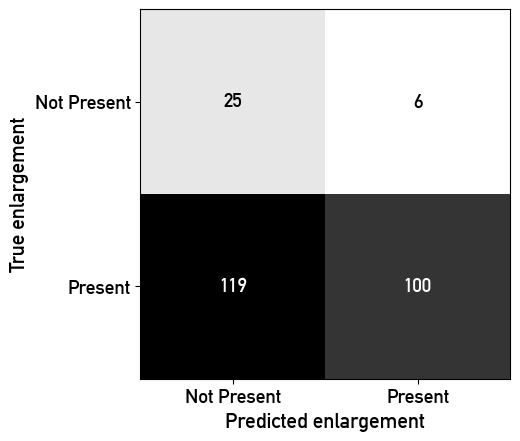

Accuracy: 0.500
Precision: 0.943
Recall: 0.457
F1 Score: 0.615


In [15]:
# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch for every operator
true_operators_all = {}
pred_operators_all = {}

for operator_name in selection_operators:
    true_operators_all[operator_name] = []
    pred_operators_all[operator_name] = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for block, operators in test_loader:
        
        # moving the features to device
        block = block.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(block)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # storing true labels and predictions for every operator
        for i, operator_name in enumerate(selection_operators):
            # extracting true and predicted operator
            true_operator_batch = operators[:,i]
            pred_operator_batch = pred_operators_labels[:,i]

            # collect data for metrics calculation
            true_operators_all[operator_name].append(true_operator_batch.cpu())
            pred_operators_all[operator_name].append(pred_operator_batch.cpu())

metrics = {"operator": [], 
           "accuracy": [], 
           "precision": [], 
           "recall": [], 
           "f1_score": []}

for operator_name in selection_operators:
    # convert lists to tensors
    cur_true_operator = torch.cat(true_operators_all[operator_name])
    cur_pred_operator = torch.cat(pred_operators_all[operator_name])

    # calculate metrics of the current operator
    conf_matrix = confusion_matrix(cur_true_operator.numpy(), cur_pred_operator.numpy())
    accuracy = accuracy_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    precision = precision_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    recall = recall_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    f1 = f1_score(cur_true_operator.numpy(), cur_pred_operator.numpy())

    # store the metrics of the current operator
    metrics["operator"].append(operator_name)
    metrics["accuracy"].append(accuracy)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1_score"].append(f1)

    # display the confusion matrix
    visualize_confusion_matrix(conf_matrix, operator=operator_name)
    
    # print metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

# saving the accuracy metrics
model_name = get_model_name(model, ops="sel", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
metrics_path = os.path.join(raster_path, "model_outputs", "selection", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame(metrics)

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

### Saving the model

In [16]:
# save the trained model to disk
path_to_models = os.path.join(raster_path, "models", "selection")

model_name = get_model_name(model, ops="sel", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

### Ideas

* Investigate effect of building size on the prediction quality? Other "confounding" factors.
* See whether including the roads actually increases the prediction performance.
* Investigate effects of imbalanced data / operator distribution.